In [3]:
import sys
from collections import namedtuple

import numpy as np

%pylab inline
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

Populating the interactive namespace from numpy and matplotlib


In [4]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

from lsst.meas.base.tests import TestDataset

from lsst.meas.base.sfm import SingleFrameMeasurementTask
from lsst.meas.base.forcedMeasurement import ForcedMeasurementTask
from lsst.meas.base.baseLib import CentroidResultKey

## Some convenience functions taken from lsst.meas.base.tests.AlgorithmTestCase:

def makeSingleFrameMeasurementConfig(plugin=None, dependencies=()):
    """Convenience function to create a Config instance for SingleFrameMeasurementTask

    The plugin and its dependencies will be the only plugins run, while the Centroid, Shape,
    and ModelFlux slots will be set to the truth fields generated by the TestDataset class.
    """
    config = SingleFrameMeasurementTask.ConfigClass()
    config.slots.centroid = "truth"
    config.slots.shape = "truth"
    config.slots.modelFlux = None
    config.slots.apFlux = None
    config.slots.psfFlux = None
    config.slots.instFlux = None
    config.slots.calibFlux = None
    config.plugins.names = (plugin,) + tuple(dependencies)
    return config

def makeSingleFrameMeasurementTask(plugin=None, dependencies=(), config=None, schema=None,
                                   algMetadata=None):
    """Convenience function to create a SingleFrameMeasurementTask with a simple configuration.
    """
    if config is None:
        if plugin is None:
            raise ValueError("Either plugin or config argument must not be None")
        config = makeSingleFrameMeasurementConfig(plugin=plugin, dependencies=dependencies)
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
        # Clear all aliases so only those defined by config are set.
        schema.setAliasMap(None)
    if algMetadata is None:
        algMetadata = lsst.daf.base.PropertyList()
    return SingleFrameMeasurementTask(schema=schema, algMetadata=algMetadata, config=config)


def makeForcedMeasurementConfig(plugin=None, dependencies=()):
    """Convenience function to create a Config instance for ForcedMeasurementTask

    In addition to the plugins specified in the plugin and dependencies arguments,
    the TransformedCentroid and TransformedShape plugins will be run and used as the
    Centroid and Shape slots; these simply transform the reference catalog centroid
    and shape to the measurement coordinate system.
    """
    config = ForcedMeasurementTask.ConfigClass()
    config.slots.centroid = "base_TransformedCentroid"
    config.slots.shape = "base_TransformedShape"
    config.slots.modelFlux = None
    config.slots.apFlux = None
    config.slots.psfFlux = None
    config.slots.instFlux = None
    config.plugins.names = (plugin,) + tuple(dependencies) + ("base_TransformedCentroid",
                                                              "base_TransformedShape")
    return config

def makeForcedMeasurementTask(plugin=None, dependencies=(), config=None, refSchema=None,
                              algMetadata=None):
    """Convenience function to create a ForcedMeasurementTask with a simple configuration.
    """
    if config is None:
        if plugin is None:
            raise ValueError("Either plugin or config argument must not be None")
        config = makeForcedMeasurementConfig(plugin=plugin, dependencies=dependencies)
    if refSchema is None:
        refSchema = TestDataset.makeMinimalSchema()
    if algMetadata is None:
        algMetadata = lsst.daf.base.PropertyList()
    return ForcedMeasurementTask(refSchema=refSchema, algMetadata=algMetadata, config=config)

In [5]:
bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(100, 100))
dataset = TestDataset(bbox)
dataset.addSource(flux=1E5, centroid=afwGeom.Point2D(25, 26))
dataset.addSource(flux=2E5, centroid=afwGeom.Point2D(75, 24), shape=afwGeom.ellipses.Quadrupole(8, 7, 2))
with dataset.addBlend() as family:
    family.addChild(flux=2E5, centroid=afwGeom.Point2D(50, 72))
    family.addChild(flux=1.5E5, centroid=afwGeom.Point2D(51, 74))
exposure, catalog = dataset.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

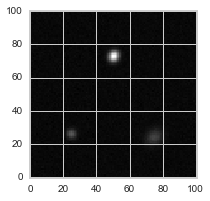

In [6]:
matplotlib.rcParams['figure.figsize'] = (3., 3.)
imgArr = exposure.getMaskedImage().getImage().getArray()
plt.imshow(imgArr, origin='lower', interpolation='none', cmap='gray')

### Make dipole by creating 2 images and subtracting 2nd from first.

I do not know how to add a negative source directly. If I do, it complains about not finding the source's footprint.

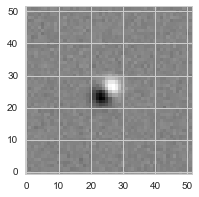

In [7]:
bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(51, 51))
dataset1 = TestDataset(bbox)
dataset1.addSource(flux=1E5, centroid=afwGeom.Point2D(26.5, 26.5))
exposure1, catalog1 = dataset1.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

dataset2 = TestDataset(bbox)
dataset2.addSource(flux=1E5, centroid=afwGeom.Point2D(23.5, 23.5))
exposure2, catalog2 = dataset2.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

img = exposure1.getMaskedImage().getImage().getArray() - exposure2.getMaskedImage().getImage().getArray()
#fpSet = catalog1.fpSet.merge(catalog2.fpSet, 1, 1, False)
plt.imshow(img, origin='lower', interpolation='none', cmap='gray')

### Time the difference between this and pure python/numpy dipole generation...

In [10]:
## First turn the above into a function...
def genDipoleAfw():
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(51, 51))
    dataset1 = TestDataset(bbox)
    dataset1.addSource(flux=1E5, centroid=afwGeom.Point2D(26.5, 26.5))
    exposure1, catalog1 = dataset1.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

    dataset2 = TestDataset(bbox)
    dataset2.addSource(flux=1E5, centroid=afwGeom.Point2D(23.5, 23.5))
    exposure2, catalog2 = dataset2.realize(noise=100.0, schema=TestDataset.makeMinimalSchema())

    img = exposure1.getMaskedImage().getImage().getArray() - exposure2.getMaskedImage().getImage().getArray()
    return img

img = genDipoleAfw()
#plt.imshow(img, origin='lower', interpolation='none', cmap='gray')

In [21]:
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, psfWidth, fluxNeg=None, sigma2=None, ampl2=0.1, afw=False):
    """
    Dipole based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    if fluxNeg is None:
        fluxNeg = flux
        
    if sigma2 is None:
        sigma2 = psfWidth * 1.75
        
    if afw:
        ## Wow - this is about 3x slower than the below (pure python)...
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, sigma2, ampl2)
        zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in xrange(len(x[0]))])
        zout *= flux
        if fluxNeg != 0. and sigma2 != 0.0:
            zout2 = np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in xrange(len(x[0]))])
            zout2 *= fluxNeg
            zout -= zout2

    else: ## don't have stack installed, use a custom double gaussian2d generator. This is faster!
        def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
            cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
            sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
            a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
            b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
            c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
            xxc, yyc = x-xc, y-yc
            out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
            if offset != 0.:
                out += offset
            return out

#      * double Guassian (sum of two Gaussians)
#      *
#      * Intended for use as a PSF model: the main Gaussian represents the core
#      * and the second Gaussian represents the wings.
#      *
#      * f(x,y) = A (e^(-r^2 / 2 sigma1^2) + ampl2 e^(-r^2 / 2 sigma2^2))
#      * where:
#      * * A = 1 / (2 pi (sigma1^2 + ampl2 sigma2^2))
#      * * r^2 = x^2 + y^2
#      * coefficients c[0] = sigma1, c[1] = sigma2, c[2] = ampl2
#       def doubleGaussian2d(x, y, xc, yc, sigma1=1., sigma2=1., ampl2=0.1):
        sigma1 = psfWidth
        multFac = 1.0 / (2. * np.pi)
        sigma1sq = sigma1**2.
        sigma2sq = sigma2**2.
        b = ampl2
#           out = (multFac / (sigma1Sq + (b * sigma2Sq))) *
#              (np.exp(-radSq / (2.0 * sigma1Sq)) + 
#              (b * np.exp(-radSq / (2.0 * sigma2Sq)))));

        #print xcenPos, xcenNeg, ycenPos, ycenNeg
        tmp1 = singleGaussian2d(x[0], x[1], xcenPos, ycenPos, sigma1, sigma1)
        tmp2 = singleGaussian2d(x[0], x[1], xcenPos, ycenPos, sigma2, sigma2)
        ampl1 = multFac / (sigma1sq + b * sigma2sq)
        zout = flux * ampl1 * (tmp1 + tmp2 * ampl2)
        if fluxNeg != 0. and sigma2 != 0.0:
            tmp1 = singleGaussian2d(x[0], x[1], xcenNeg, ycenNeg, sigma1, sigma1)
            tmp2 = singleGaussian2d(x[0], x[1], xcenNeg, ycenNeg, sigma2, sigma2)
            zout2 = fluxNeg * ampl1 * (tmp1 + tmp2 * ampl2)
            zout -= zout2

    return zout

def genDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.0, flux=3000., noise=1., display=False,
             afw=False):
    y, x = np.mgrid[:w, :h]
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    z = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad), psfWidth, afw=afw) #, psfWidth, psfWidth*1.75)
    ## TBD: accurate (poisson) noise proportional to pixel intensity
    z += np.random.normal(0., noise, x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    if display:
        zptp = z.ptp() / 2.
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
        plt.title("Data")

    return x.reshape(w, h), y.reshape(w, h), z.reshape(w, h)

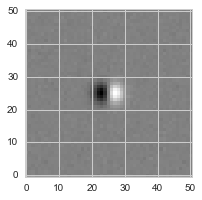

In [17]:
_, _, img = genDipole(51, 51, 25., 25.)
plt.imshow(img, origin='lower', interpolation='none', cmap='gray')

In [18]:
%timeit img = genDipoleAfw()

100 loops, best of 3: 2.28 ms per loop


In [19]:
%timeit _, _, img = genDipole(51, 51, 25., 25.)

1000 loops, best of 3: 395 µs per loop


In [22]:
%timeit _, _, img = genDipole(51, 51, 25., 25., afw=True)

100 loops, best of 3: 17.1 ms per loop


### Clearly the python routine is faster, although the `afw` routine does detection (?) and/or footprinting as well.